## Validate ResNet 3

### created by Yuying Liu, 07/19/2020

This script is meant to study the robustness of our results with respect to noise in the observations of the system. The variances are set to be 0% (noise free), 1%, and 2% of the variance of that component averaged over all trajectories across the data sets. We find our multiscale scheme is consistently better than any single time-scale neural network time-steppers.

This script can be used to reproduce:
- Figure 6A
- Figure 8
- Table 6 - 8

In [2]:
import os
import sys
import torch
import numpy as np
import scipy.interpolate
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


module_path = os.path.abspath(os.path.join('../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import ResNet as net

In [3]:
# adjustables

dt = 0.01                     # time unit: 0.0005 for Lorenz and 0.01 for others
system = 'Hyperbolic'         # system name: 'Hyperbolic', 'Cubic', 'VanDerPol', 'Hopf' or 'Lorenz'            
noise = 0.                    # noise level: 0.00, 0.01 or 0.02

In [4]:
# path
data_dir = os.path.join('../../data/', system)
model_dir = os.path.join('../../models/', system)

# global const
ks = list(range(11))
step_sizes = [2**k for k in ks]

In [5]:
# load data
val_data = np.load(os.path.join(data_dir, 'val_noise{}.npy'.format(noise)))
test_data = np.load(os.path.join(data_dir, 'test_noise{}.npy'.format(noise)))

In [6]:
# load models
models = list()
for step_size in step_sizes:
    print('load model_D{}.pt'.format(step_size))
    models.append(torch.load(os.path.join(model_dir, 'model_D{}_noise{}.pt'.format(step_size, noise)), map_location='cpu'))

# fix model consistencies trained on gpus (optional)
for model in models:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()

load model_D1.pt
load model_D2.pt
load model_D4.pt
load model_D8.pt
load model_D16.pt
load model_D32.pt
load model_D64.pt
load model_D128.pt
load model_D256.pt
load model_D512.pt
load model_D1024.pt


/Users/liuyuyingufo/miniconda3/envs/HiTS/lib/python3.7/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'ResNet.ResNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/liuyuyingufo/miniconda3/envs/HiTS/lib/python3.7/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/liuyuyingufo/miniconda3/envs/HiTS/lib/python3.7/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the ori

### Part I: benchmarks

In [7]:
# shared info
n_steps = test_data.shape[1] - 1
t = [dt*(step+1) for step in range(n_steps)]
criterion = torch.nn.MSELoss()

In [8]:
# uniscale time-stepping with NN 
preds_mse = list()

for model in tqdm(models):
    y_preds = model.uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
    preds_mse.append(criterion(torch.tensor(test_data[:, 2:, :]).float(), y_preds[:, 1:, :]))

/Users/liuyuyingufo/Documents/UW_docs/Data_driven_dyn_research/multiscale_HiTS/src/ResNet.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))
/Users/liuyuyingufo/miniconda3/envs/HiTS/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/liuyuyingufo/miniconda3/envs/HiTS/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:608: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


In [9]:
# model selections 
start_idx = 0
end_idx = len(models)
best_mse = 1e+5
# choose the largest time step
for i in tqdm(range(len(models))):
    y_preds = net.vectorized_multi_scale_forecast(torch.tensor(val_data[:, 0, :]).float(), n_steps=n_steps, models=models[:len(models)-i])
    mse = criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds).mean().item()
    if mse <= best_mse:
        end_idx = len(models)-i
        best_mse = mse

        # choose the smallest time step
for i in tqdm(range(end_idx)):
    y_preds = net.vectorized_multi_scale_forecast(torch.tensor(val_data[:, 0, :]).float(), n_steps=n_steps, models=models[i:end_idx])
    mse = criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds).mean().item()
    if mse <= best_mse:
        start_idx = i
        best_mse = mse
        
print('use models {} - {}.'.format(start_idx, end_idx))
models = models[start_idx:end_idx]


use models 3 - 10.


In [10]:
# multiscale time-stepping with NN
y_preds = net.vectorized_multi_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps, models=models)
multiscale_preds_mse = criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds)

In [11]:
# each time we run Part I, we print, collect and copy-paste the data below in Part II to make the plots
print([e.item() for e in preds_mse])
print(multiscale_preds_mse.item())

[0.001457706792280078, 0.00024915850372053683, 1.6942834918154404e-05, 1.6876583686098456e-05, 1.5089919997990364e-06, 1.8038350617644028e-06, 4.82757559439051e-06, 5.405044794315472e-05, 0.0005424169939942658, 0.003191528841853142, 0.010530899278819561]
5.0908646187508566e-08


### Part II: collect data and plot

In [12]:
hyperbolic_times = [10.06, 3.75, 1.89, 1.01, 0.56, 0.34, 0.24, 0.18, 0.15, 0.13, 0.12, 0.89]
cubic_times = [24.74, 7.68, 3.62, 1.84, 1.00, 0.77, 0.65, 0.39, 0.27, 0.17, 0.14, 6.73]
vanderpol_times = [48.95, 21.48, 8.74, 4.00, 2.06, 1.09, 0.60, 0.36, 0.24, 0.19, 0.15, 8.88]
hopf_times = [9.98, 3.69, 1.87, 1.03, 0.59, 0.37, 0.27, 0.22, 0.21, 0.17, 0.17, 1.84]
lorenz_times = [42.99, 19.01, 8.51, 4.10, 2.03, 1.09, 0.56, 0.30, 0.18, 0.12, 0.09, 0.72]

In [13]:
"""noise free"""
hyperbolic_errs_0 = [1.5e-3, 2.0e-4, 1.7e-5, 1.6e-5, 1.5e-6, 1.8e-6, 4.8e-6, 5.4e-5, 5.0e-4, 3.2e-3, 1.0e-2, 5.1e-8]
cubic_errs_0 = [3.1e-3, 7.0e-4, 4.0e-4, 2.0e-4, 3.0e-4, 3.0e-4, 3.0e-4, 1.2e-3, 9.8e-3, 5.0e-2, 1.0e-1, 2.0e-4]
vanderpol_errs_0 = [1.3e-1, 6.9e-3, 3.3e-3, 4.1e-3, 3.9e-3, 2.2e-2, 9.3e-2, 4.2e-1, 1.0e+0, 2.9e+0, 3.2e+0, 3.2e-3]
hopf_errs_0 = [4.9e-3, 1.2e-3, 1.2e-3, 1.1e-3, 9.0e-4, 9.0e-4, 9.0e-4, 2.5e-3, 2.4e-2, 1.5e-1, 1.3e-1, 4.1e-5]
lorenz_errs_0 = [1.6e+1, 2.2e+1, 1.5e+1, 8.0e+0, 2.5e+1, 4.4e+0, 4.1e+0, 4.7e+0, 5.6e+0, 1.8e+1, 5.1e+1, 4.1e+0]

In [14]:
"""1% noise"""
hyperbolic_errs_1 = [7.2e-3, 4.9e-3, 5.0e-5, 7.8e-5, 7.3e-5, 5.8e-5, 9.5e-6, 5.7e-5, 5.0e-4, 3.2e-3, 1.0e-2, 1.7e-6]
cubic_errs_1 = [3.4e-2, 2.7e-2, 6.4e-3, 3.9e-3, 1.3e-3, 1.1e-3, 8.0e-4, 1.7e-3, 1.0e-2, 5.0e-2, 1.0e-1, 6.0e-4]
vanderpol_errs_1 = [1.6e+0, 3.1e+0, 2.4e+0, 1.6e-1, 7.8e-2, 9.0e-2, 1.2e-1, 4.2e-1, 1.0e+0, 2.9e+0, 3.2e+0, 1.7e-2]
hopf_errs_1 = [1.9e-2, 5.9e-3, 1.2e-2, 7.0e-3, 1.2e-3, 1.0e-3, 7.0e-4, 2.4e-3, 2.4e-2, 1.5e-1, 1.3e-1, 5.4e-5]
lorenz_errs_1 = [9.0e+1, 4.1e+1, 3.4e+1, 2.8e+1, 1.9e+1, 1.3e+1, 9.7e+0, 1.1e+1, 1.2e+1, 2.3e+1, 5.2e+1, 9.8e+0]

In [15]:
"""2% noise"""
hyperbolic_errs_2 = [1.3e-2, 3.1e-3, 2.5e-3, 2.0e-4, 4.5e-5, 2.7e-5, 1.3e-5, 6.1e-5, 5.0e-4, 3.2e-3, 1.1e-2, 6.1e-6]
cubic_errs_2 = [7.8e-2, 3.1e-2, 1.3e-2, 5.3e-3, 2.6e-3, 2.1e-3, 2.0e-3, 3.0e-3, 1.1e-2, 5.2e-2, 1.0e-1, 1.6e-3]
vanderpol_errs_2 = [1.6e+0, 3.1e+0, 2.4e+0, 1.6e-1, 7.8e-2, 9.0e-2, 1.2e-1, 4.2e-1, 1.0e+0, 2.9e+0, 3.2e+0, 1.7e-2]
hopf_errs_2 = [4.2e-2, 1.1e-2, 8.5e-2, 2.1e-3, 1.0e-3, 1.0e-3, 8.0e-4, 2.4e-3, 2.4e-2, 1.5e-1, 1.3e-1, 9.0e-5]
lorenz_errs_2 = [1.1e+2, 6.8e+1, 4.5e+1, 4.9e+1, 2.2e+1, 1.9e+1, 1.9e+1, 1.6e+1, 1.9e+1, 2.8e+1, 5.2e+1, 1.6e+1]

(array([-8., -6., -4., -2.,  0.,  2.,  4.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

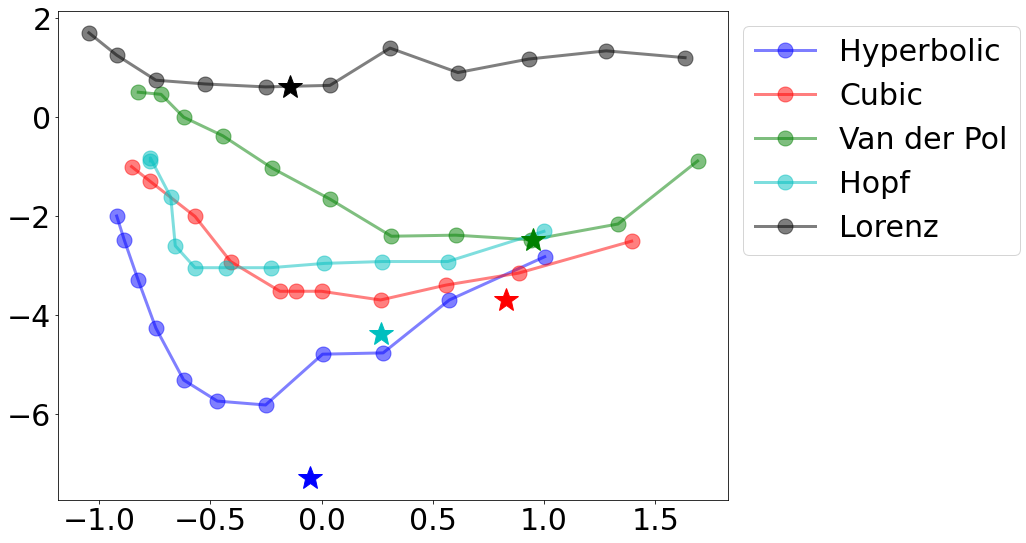

In [22]:
fig = plt.figure(figsize=(12, 9))
plt.plot(np.log10(hyperbolic_times[:-1]), np.log10(hyperbolic_errs_0[:-1]), 'b-o', markersize=15, linewidth=3.0, alpha=0.5, label='Hyperbolic')
plt.plot(np.log10(cubic_times[:-1]), np.log10(cubic_errs_0[:-1]), 'r-o', markersize=15, linewidth=3.0, alpha=0.5, label='Cubic')
plt.plot(np.log10(vanderpol_times[:-1]), np.log10(vanderpol_errs_0[:-1]), 'g-o', markersize=15, linewidth=3.0, alpha=0.5, label='Van der Pol')
plt.plot(np.log10(hopf_times[:-1]), np.log10(hopf_errs_0[:-1]), 'c-o', markersize=15, linewidth=3.0, alpha=0.5, label='Hopf')
plt.plot(np.log10(lorenz_times[:-1]), np.log10(lorenz_errs_0[:-1]), 'k-o', markersize=15, linewidth=3.0, alpha=0.5, label='Lorenz')
plt.plot(np.log10(hyperbolic_times[-1]), np.log10(hyperbolic_errs_0[-1]), 'b*', 
         np.log10(cubic_times[-1]), np.log10(cubic_errs_0[-1]), 'r*', 
         np.log10(vanderpol_times[-1]), np.log10(vanderpol_errs_0[-1]), 'g*', 
         np.log10(hopf_times[-1]), np.log10(hopf_errs_0[-1]), 'c*', 
         np.log10(lorenz_times[-1]), np.log10(lorenz_errs_0[-1]), 'k*', 
         markersize=25)

plt.legend(bbox_to_anchor=(1, 1), fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

(array([-7., -6., -5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

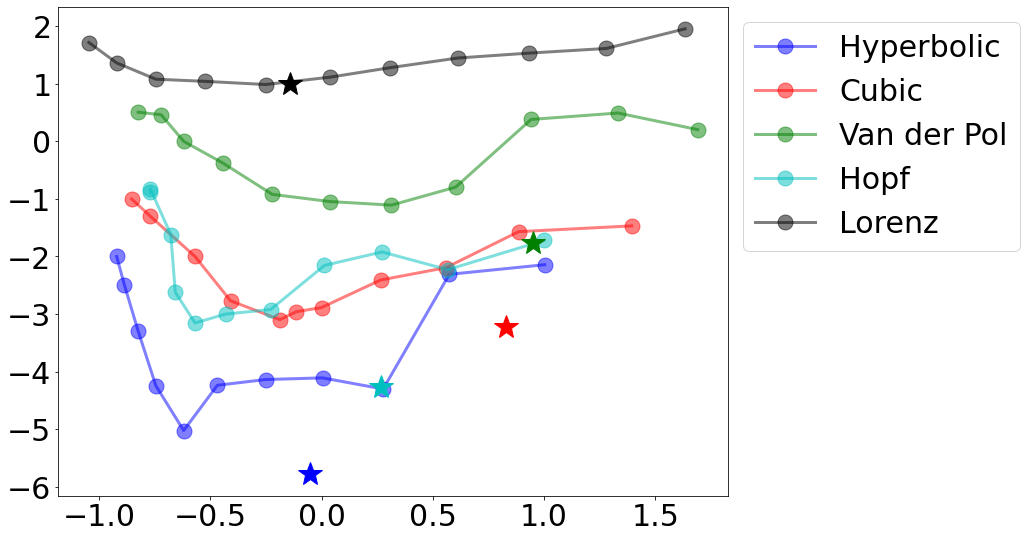

In [20]:
fig = plt.figure(figsize=(12, 9))
plt.plot(np.log10(hyperbolic_times[:-1]), np.log10(hyperbolic_errs_1[:-1]), 'b-o', markersize=15, linewidth=3.0, alpha=0.5, label='Hyperbolic')
plt.plot(np.log10(cubic_times[:-1]), np.log10(cubic_errs_1[:-1]), 'r-o', markersize=15, linewidth=3.0, alpha=0.5, label='Cubic')
plt.plot(np.log10(vanderpol_times[:-1]), np.log10(vanderpol_errs_1[:-1]), 'g-o', markersize=15, linewidth=3.0, alpha=0.5, label='Van der Pol')
plt.plot(np.log10(hopf_times[:-1]), np.log10(hopf_errs_1[:-1]), 'c-o', markersize=15, linewidth=3.0, alpha=0.5, label='Hopf')
plt.plot(np.log10(lorenz_times[:-1]), np.log10(lorenz_errs_1[:-1]), 'k-o', markersize=15, linewidth=3.0, alpha=0.5, label='Lorenz')
plt.plot(np.log10(hyperbolic_times[-1]), np.log10(hyperbolic_errs_1[-1]), 'b*', markersize=25)
plt.plot(np.log10(cubic_times[-1]), np.log10(cubic_errs_1[-1]), 'r*', markersize=25)
plt.plot(np.log10(vanderpol_times[-1]), np.log10(vanderpol_errs_1[-1]), 'g*', markersize=25)
plt.plot(np.log10(hopf_times[-1]), np.log10(hopf_errs_1[-1]), 'c*', markersize=25)
plt.plot(np.log10(lorenz_times[-1]), np.log10(lorenz_errs_1[-1]), 'k*', markersize=25)

plt.legend(bbox_to_anchor=(1, 1), fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

(array([-6., -5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

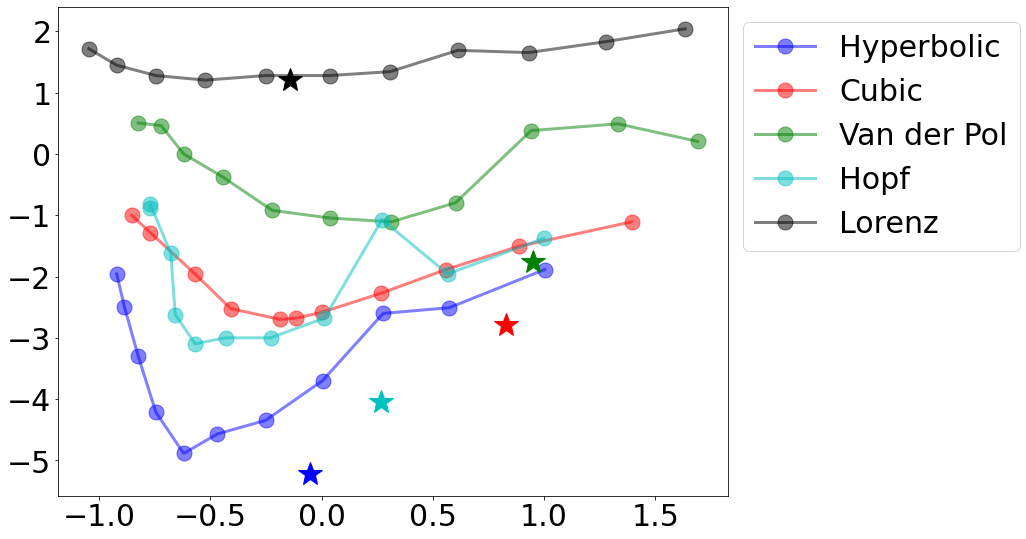

In [21]:
fig = plt.figure(figsize=(12, 9))
plt.plot(np.log10(hyperbolic_times[:-1]), np.log10(hyperbolic_errs_2[:-1]), 'b-o', markersize=15, linewidth=3.0, alpha=0.5, label='Hyperbolic')
plt.plot(np.log10(cubic_times[:-1]), np.log10(cubic_errs_2[:-1]), 'r-o', markersize=15, linewidth=3.0, alpha=0.5, label='Cubic')
plt.plot(np.log10(vanderpol_times[:-1]), np.log10(vanderpol_errs_2[:-1]), 'g-o', markersize=15, linewidth=3.0, alpha=0.5, label='Van der Pol')
plt.plot(np.log10(hopf_times[:-1]), np.log10(hopf_errs_2[:-1]), 'c-o', markersize=15, linewidth=3.0, alpha=0.5, label='Hopf')
plt.plot(np.log10(lorenz_times[:-1]), np.log10(lorenz_errs_2[:-1]), 'k-o', markersize=15, linewidth=3.0, alpha=0.5, label='Lorenz')
plt.plot(np.log10(hyperbolic_times[-1]), np.log10(hyperbolic_errs_2[-1]), 'b*', markersize=25)
plt.plot(np.log10(cubic_times[-1]), np.log10(cubic_errs_2[-1]), 'r*', markersize=25)
plt.plot(np.log10(vanderpol_times[-1]), np.log10(vanderpol_errs_2[-1]), 'g*', markersize=25)
plt.plot(np.log10(hopf_times[-1]), np.log10(hopf_errs_2[-1]), 'c*', markersize=25)
plt.plot(np.log10(lorenz_times[-1]), np.log10(lorenz_errs_2[-1]), 'k*', markersize=25)

plt.legend(bbox_to_anchor=(1, 1), fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)